In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm
import pickle
from sklearn.preprocessing import StandardScaler
import math

In [2]:
kfold_seed = 0
models_seed = 0
np_seed = 0

# Compute Gini metric functions

In [3]:
# from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini
    
    
# Funcitons from olivier's kernel
# https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

# Target encoding functions

In [4]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,    # Revised to encode validation series
                  val_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_val_series = pd.merge(
        val_series.to_frame(val_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=val_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_val_series.index = val_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)


# def target_encode_2(trn_series, val_series, tst_series, target):
    

# Read data

In [5]:
# Read data
train_df = pd.read_csv('data/train.csv', na_values="-1") 
test_df = pd.read_csv('data/test.csv', na_values="-1")

# Features to use

In [6]:
# Nulls count, not tested
train_df['nulls_count'] = train_df.isnull().sum(axis=1)
test_df['nulls_count'] = test_df.isnull().sum(axis=1)

# from olivier
train_features = [
    "ps_car_13",  #            : 1571.65 / shadow  609.23
	"ps_reg_03",  #            : 1408.42 / shadow  511.15
	"ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
	"ps_ind_03",  #            : 1219.47 / shadow  230.55
	"ps_ind_15",  #            :  922.18 / shadow  242.00
	"ps_reg_02",  #            :  920.65 / shadow  267.50
	"ps_car_14",  #            :  798.48 / shadow  549.58
	"ps_car_12",  #            :  731.93 / shadow  293.62
	"ps_car_01_cat",  #        :  698.07 / shadow  178.72
	"ps_car_07_cat",  #        :  694.53 / shadow   36.35
	"ps_ind_17_bin",  #        :  620.77 / shadow   23.15
	"ps_car_03_cat",  #        :  611.73 / shadow   50.67
	"ps_reg_01",  #            :  598.60 / shadow  178.57
	"ps_car_15",  #            :  593.35 / shadow  226.43
	"ps_ind_01",  #            :  547.32 / shadow  154.58
	"ps_ind_16_bin",  #        :  475.37 / shadow   34.17
	"ps_ind_07_bin",  #        :  435.28 / shadow   28.92
	"ps_car_06_cat",  #        :  398.02 / shadow  212.43
	"ps_car_04_cat",  #        :  376.87 / shadow   76.98
	"ps_ind_06_bin",  #        :  370.97 / shadow   36.13
	"ps_car_09_cat",  #        :  214.12 / shadow   81.38
	"ps_car_02_cat",  #        :  203.03 / shadow   26.67
	"ps_ind_02_cat",  #        :  189.47 / shadow   65.68
	"ps_car_11",  #            :  173.28 / shadow   76.45
	"ps_car_05_cat",  #        :  172.75 / shadow   62.92
	"ps_calc_09",  #           :  169.13 / shadow  129.72
	"ps_calc_05",  #           :  148.83 / shadow  120.68
	"ps_ind_08_bin",  #        :  140.73 / shadow   27.63
	"ps_car_08_cat",  #        :  120.87 / shadow   28.82
	"ps_ind_09_bin",  #        :  113.92 / shadow   27.05
	"ps_ind_04_cat",  #        :  107.27 / shadow   37.43
	"ps_ind_18_bin",  #        :   77.42 / shadow   25.97
	"ps_ind_12_bin",  #        :   39.67 / shadow   15.52
	"ps_ind_14",  #            :   37.37 / shadow   16.65
    #"nulls_count" #            : not analized
]
# add combinations
combs = [
    ('ps_reg_01', 'ps_car_02_cat'),  
    ('ps_reg_01', 'ps_car_04_cat'),
    ('ps_ind_02_cat', 'ps_ind_03')
    #ps_ind_05_cat|ps_ind_16_bin
]

# Extra feature engineering

In [7]:
#sum_ps_ind_03_ps_calc_02	0.2891251923	VALIDATOIN
#diff_ps_ind_03_ps_ind_15	0.289420424	VALIDATOIN SCORE IMPROVED!!
train_df['sum_ps_ind_03_ps_calc_02'] = (train_df['ps_ind_03'] + train_df['ps_calc_02']).astype(np.float32)
test_df['sum_ps_ind_03_ps_calc_02'] = (test_df['ps_ind_03'] + test_df['ps_calc_02']).astype(np.float32)
train_features.append('sum_ps_ind_03_ps_calc_02')
train_df['diff_ps_ind_03_ps_ind_15'] = (train_df['ps_ind_03'] + train_df['ps_ind_15']).astype(np.float32)
test_df['diff_ps_ind_03_ps_ind_15'] = (test_df['ps_ind_03'] + test_df['ps_ind_15']).astype(np.float32)
train_features.append('diff_ps_ind_03_ps_ind_15')

# Preprocess data

In [8]:
# Process data
id_test = test_df['id'].values
id_train = train_df['id'].values
y = train_df['target']

start = time.time()
for n_c, (f1, f2) in enumerate(combs):
    name1 = f1 + "_plus_" + f2
    print('current feature %60s %4d in %5.1f'
          % (name1, n_c + 1, (time.time() - start) / 60), end='')
    print('\r' * 75, end='')
    train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
    test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
    # Label Encode
    lbl = LabelEncoder()
    lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
    train_df[name1] = lbl.transform(list(train_df[name1].values))
    test_df[name1] = lbl.transform(list(test_df[name1].values))

    train_features.append(name1)
    
X = train_df[train_features]
test_df = test_df[train_features]

f_cats = [f for f in X.columns if "_cat" in f]
f_bin = [f for f in X.columns if "_bin" in f]

# Feature Sets

In [9]:
feature_sets = {}
feature_sets['FS1'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_05_cat', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12', 'ps_car_01_cat', 'ps_car_07_cat',
       'ps_ind_17_bin', 'ps_car_03_cat', 'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_ind_16_bin', 'ps_ind_07_bin', 'ps_car_06_cat', 'ps_car_04_cat',
       'ps_ind_06_bin', 'ps_car_09_cat', 'ps_car_02_cat', 'ps_ind_02_cat',
       'ps_car_11', 'ps_car_05_cat', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_08_bin', 'ps_car_08_cat', 'ps_ind_09_bin', 'ps_ind_04_cat',
       'ps_ind_18_bin', 'ps_ind_12_bin', 'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       'ps_reg_01_plus_ps_car_02_cat', 'ps_reg_01_plus_ps_car_04_cat',
       'ps_ind_02_cat_plus_ps_ind_03', 'ps_ind_05_cat_avg',
       'ps_car_01_cat_avg', 'ps_car_07_cat_avg', 'ps_car_03_cat_avg',
       'ps_car_06_cat_avg', 'ps_car_04_cat_avg', 'ps_car_09_cat_avg',
       'ps_car_02_cat_avg', 'ps_ind_02_cat_avg', 'ps_car_05_cat_avg',
       'ps_car_08_cat_avg', 'ps_ind_04_cat_avg',
       'ps_reg_01_plus_ps_car_02_cat_avg', 'ps_reg_01_plus_ps_car_04_cat_avg',
       'ps_ind_02_cat_plus_ps_ind_03_avg']

feature_sets['FS2'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12',
       'ps_ind_17_bin', 'ps_car_03_cat', 'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_ind_16_bin', 'ps_ind_07_bin', 
       'ps_ind_06_bin', 
       'ps_car_11', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_18_bin', 'ps_ind_12_bin', 'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       'ps_ind_02_cat_plus_ps_ind_03', 'ps_ind_05_cat_avg',
       'ps_car_01_cat_avg', 'ps_car_07_cat_avg', 'ps_car_03_cat_avg',
       'ps_car_06_cat_avg', 'ps_car_04_cat_avg', 'ps_car_09_cat_avg',
       'ps_car_02_cat_avg', 'ps_ind_02_cat_avg', 'ps_car_05_cat_avg',
       'ps_car_08_cat_avg', 'ps_ind_04_cat_avg',
       'ps_reg_01_plus_ps_car_02_cat_avg', 'ps_reg_01_plus_ps_car_04_cat_avg',
       'ps_ind_02_cat_plus_ps_ind_03_avg', 'logsum_mean_target_all']

# Same than FS2, but without logsum
feature_sets['FS3'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12',
       'ps_ind_17_bin', 'ps_car_03_cat', 'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_ind_16_bin', 'ps_ind_07_bin', 
       'ps_ind_06_bin', 
       'ps_car_11', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_18_bin', 'ps_ind_12_bin', 'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       #'ps_ind_02_cat_plus_ps_ind_03', 
       'ps_ind_05_cat_avg',
       'ps_car_01_cat_avg', 'ps_car_07_cat_avg', 'ps_car_03_cat_avg',
       'ps_car_06_cat_avg', 'ps_car_04_cat_avg', 'ps_car_09_cat_avg',
       'ps_car_02_cat_avg', 'ps_ind_02_cat_avg', 'ps_car_05_cat_avg',
       'ps_car_08_cat_avg', 'ps_ind_04_cat_avg',
       'ps_reg_01_plus_ps_car_02_cat_avg', 'ps_reg_01_plus_ps_car_04_cat_avg',
       'ps_ind_02_cat_plus_ps_ind_03_avg']

# Same than FS3, but changing mean target by bayes prob and without logsum
feature_sets['FS4'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12',
       'ps_ind_17_bin', 'ps_car_03_cat', 'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_ind_16_bin', 'ps_ind_07_bin', 
       'ps_ind_06_bin', 
       'ps_car_11', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_08_bin', 'ps_ind_09_bin',
       'ps_ind_18_bin', 'ps_ind_12_bin', 'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       #'ps_ind_02_cat_plus_ps_ind_03', 
       'ps_ind_05_cat_bayes_prob', 'ps_car_01_cat_bayes_prob',
       'ps_car_07_cat_bayes_prob', 'ps_car_03_cat_bayes_prob',
       'ps_car_06_cat_bayes_prob', 'ps_car_04_cat_bayes_prob',
       'ps_car_09_cat_bayes_prob', 'ps_car_02_cat_bayes_prob',
       'ps_ind_02_cat_bayes_prob', 'ps_car_05_cat_bayes_prob',
       'ps_car_08_cat_bayes_prob', 'ps_ind_04_cat_bayes_prob',
       'ps_reg_01_plus_ps_car_02_cat_bayes_prob',
       'ps_reg_01_plus_ps_car_04_cat_bayes_prob',
       'ps_ind_02_cat_plus_ps_ind_03_bayes_prob']

# Same than FS1, Added binaries avg target
feature_sets['FS5'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_05_cat', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12', 'ps_car_01_cat', 'ps_car_07_cat',
       'ps_ind_17_bin', 'ps_car_03_cat', 'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_ind_16_bin', 'ps_ind_07_bin', 'ps_car_06_cat', 'ps_car_04_cat',
       'ps_ind_06_bin', 'ps_car_09_cat', 'ps_car_02_cat', 'ps_ind_02_cat',
       'ps_car_11', 'ps_car_05_cat', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_08_bin', 'ps_car_08_cat', 'ps_ind_09_bin', 'ps_ind_04_cat',
       'ps_ind_18_bin', 'ps_ind_12_bin', 'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       'ps_reg_01_plus_ps_car_02_cat', 'ps_reg_01_plus_ps_car_04_cat',
       'ps_ind_02_cat_plus_ps_ind_03', 'ps_ind_05_cat_avg',
       'ps_car_01_cat_avg', 'ps_car_07_cat_avg', 'ps_car_03_cat_avg',
       'ps_car_06_cat_avg', 'ps_car_04_cat_avg', 'ps_car_09_cat_avg',
       'ps_car_02_cat_avg', 'ps_ind_02_cat_avg', 'ps_car_05_cat_avg',
       'ps_car_08_cat_avg', 'ps_ind_04_cat_avg',
       'ps_reg_01_plus_ps_car_02_cat_avg', 'ps_reg_01_plus_ps_car_04_cat_avg',
       'ps_ind_02_cat_plus_ps_ind_03_avg', 'logsum_mean_target_all',
       'ps_ind_17_bin_avg', 'ps_ind_16_bin_avg', 'ps_ind_07_bin_avg', 'ps_ind_09_bin_avg',
       'ps_ind_06_bin_avg', 'ps_ind_08_bin_avg', 'ps_ind_18_bin_avg', 'ps_ind_12_bin_avg',
      ]

# Same than FS5, but removing the variables that are encoded my mean target (cat and bin)
feature_sets['FS6'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12', 
       'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_car_11', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       'ps_ind_02_cat_plus_ps_ind_03', 'ps_ind_05_cat_avg',
       'ps_car_01_cat_avg', 'ps_car_07_cat_avg', 'ps_car_03_cat_avg',
       'ps_car_06_cat_avg', 'ps_car_04_cat_avg', 'ps_car_09_cat_avg',
       'ps_car_02_cat_avg', 'ps_ind_02_cat_avg', 'ps_car_05_cat_avg',
       'ps_car_08_cat_avg', 'ps_ind_04_cat_avg',
       'ps_reg_01_plus_ps_car_02_cat_avg', 'ps_reg_01_plus_ps_car_04_cat_avg',
       'ps_ind_02_cat_plus_ps_ind_03_avg', 'logsum_mean_target_all',
       'ps_ind_17_bin_avg', 'ps_ind_16_bin_avg', 'ps_ind_07_bin_avg', 'ps_ind_09_bin_avg',
       'ps_ind_06_bin_avg', 'ps_ind_08_bin_avg', 'ps_ind_18_bin_avg', 'ps_ind_12_bin_avg',
      ]


# Same than FS4, but adding cat vars
feature_sets['FS7'] = ['ps_car_13', 'ps_reg_03', 'ps_ind_05_cat', 'ps_ind_03', 'ps_ind_15',
       'ps_reg_02', 'ps_car_14', 'ps_car_12', 'ps_car_01_cat', 'ps_car_07_cat',
       'ps_ind_17_bin', 'ps_car_03_cat', 'ps_reg_01', 'ps_car_15', 'ps_ind_01',
       'ps_ind_16_bin', 'ps_ind_07_bin', 'ps_car_06_cat', 'ps_car_04_cat',
       'ps_ind_06_bin', 'ps_car_09_cat', 'ps_car_02_cat', 'ps_ind_02_cat',
       'ps_car_11', 'ps_car_05_cat', 'ps_calc_09', 'ps_calc_05',
       'ps_ind_08_bin', 'ps_car_08_cat', 'ps_ind_09_bin', 'ps_ind_04_cat',
       'ps_ind_18_bin', 'ps_ind_12_bin', 'ps_ind_14',
       'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15',
       'ps_reg_01_plus_ps_car_02_cat', 'ps_reg_01_plus_ps_car_04_cat',
       'ps_ind_02_cat_plus_ps_ind_03', 
       'ps_ind_05_cat_bayes_prob', 'ps_car_01_cat_bayes_prob',
       'ps_car_07_cat_bayes_prob', 'ps_car_03_cat_bayes_prob',
       'ps_car_06_cat_bayes_prob', 'ps_car_04_cat_bayes_prob',
       'ps_car_09_cat_bayes_prob', 'ps_car_02_cat_bayes_prob',
       'ps_ind_02_cat_bayes_prob', 'ps_car_05_cat_bayes_prob',
       'ps_car_08_cat_bayes_prob', 'ps_ind_04_cat_bayes_prob',
       'ps_reg_01_plus_ps_car_02_cat_bayes_prob',
       'ps_reg_01_plus_ps_car_04_cat_bayes_prob',
       'ps_ind_02_cat_plus_ps_ind_03_bayes_prob']

#
use_as_cat_features = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01',
                            'ps_reg_02', 'ps_car_11']
new_mean_encoded_features = ['ps_ind_01_avg', 'ps_ind_03_avg', 'ps_ind_14_avg', 'ps_ind_15_avg', 'ps_reg_01_avg',
                            'ps_reg_02_avg', 'ps_car_11_avg']

feature_sets['FS8'] = feature_sets['FS1'] + new_mean_encoded_features
feature_sets['FS9'] = feature_sets['FS2'] + new_mean_encoded_features
feature_sets['FS10'] = feature_sets['FS3'] + new_mean_encoded_features
feature_sets['FS11'] = feature_sets['FS6'] + new_mean_encoded_features
feature_sets['FS12'] = feature_sets['FS7'] + new_mean_encoded_features

feature_sets['FS13'] = [f for f in feature_sets['FS8'] if f not in use_as_cat_features]
feature_sets['FS14'] = [f for f in feature_sets['FS9'] if f not in use_as_cat_features]
feature_sets['FS15'] = [f for f in feature_sets['FS10'] if f not in use_as_cat_features]
feature_sets['FS16'] = [f for f in feature_sets['FS11'] if f not in use_as_cat_features]
feature_sets['FS17'] = [f for f in feature_sets['FS12'] if f not in use_as_cat_features]



# Setup classifiers

In [10]:
# XGBoost
xgb1_params = {}
xgb1_params['objective'] = "binary:logistic"
xgb1_params['n_estimators'] = 400 # MAX_ROUNDS
xgb1_params['learning_rate'] = 0.07
xgb1_params['max_depth'] = 4
xgb1_params['subsample'] = 0.80
xgb1_params['colsample_bytree'] = 0.80
xgb1_params['min_child_weight'] = 6
xgb1_params['gamma'] = 10
xgb1_params['reg_alpha'] = 8
xgb1_params['reg_lambda'] = 1.5
xgb1_params['scale_pos_weight'] = 1.6
#xgb1_params['max_delta_step'] = 0
xgb1_params['seed'] = models_seed
xgb1 = XGBClassifier(**xgb1_params)

xgb2_params = {}
xgb2_params['objective'] = "count:poisson"
xgb2_params['n_estimators'] = 400 # MAX_ROUNDS
xgb2_params['learning_rate'] = 0.06
xgb2_params['max_depth'] = 4
xgb2_params['subsample'] = 0.85
xgb2_params['colsample_bytree'] = 0.82
xgb2_params['min_child_weight'] = 8
xgb2_params['gamma'] = 9
xgb2_params['reg_alpha'] = 8
xgb2_params['reg_lambda'] = 1.5
xgb2_params['scale_pos_weight'] = 1.6
xgb2_params['seed'] = models_seed
xgb2 = XGBClassifier(**xgb2_params)

xgb3_params = {}
xgb3_params['objective'] = "binary:logistic"
xgb3_params['n_estimators'] = 420 # MAX_ROUNDS
xgb3_params['learning_rate'] = 0.05
xgb3_params['max_depth'] = 5
xgb3_params['subsample'] = 0.80
xgb3_params['colsample_bytree'] = 0.80
xgb3_params['min_child_weight'] = 6
xgb3_params['gamma'] = 10
xgb3_params['reg_alpha'] = 8
xgb3_params['reg_lambda'] = 1.5
xgb3_params['scale_pos_weight'] = 1.6
#xgb1_params['max_delta_step'] = 0
xgb3_params['seed'] = models_seed
xgb3 = XGBClassifier(**xgb3_params)

# LightGBM
lgb1_params = {}
lgb1_params['learning_rate'] = 0.02
lgb1_params['n_estimators'] = 650
lgb1_params['max_bin'] = 10
lgb1_params['subsample'] = 0.8
lgb1_params['subsample_freq'] = 10
lgb1_params['colsample_bytree'] = 0.8   
lgb1_params['min_child_samples'] = 500
lgb1_params['seed'] = models_seed
lgb1 = LGBMClassifier(**lgb1_params)

lgb2_params = {}
lgb2_params['n_estimators'] = 1090
lgb2_params['learning_rate'] = 0.02
lgb2_params['colsample_bytree'] = 0.3   
lgb2_params['subsample'] = 0.7
lgb2_params['subsample_freq'] = 2
lgb2_params['num_leaves'] = 16
lgb2_params['seed'] = 99
lgb2 = LGBMClassifier(**lgb2_params)

# LightGBM
lgb3_params = {}
lgb3_params['learning_rate'] = 0.02
lgb3_params['n_estimators'] = 650
lgb3_params['max_bin'] = 10
lgb3_params['subsample'] = 0.8
lgb3_params['subsample_freq'] = 10
lgb3_params['colsample_bytree'] = 0.8   
lgb3_params['min_child_samples'] = 500
lgb3_params['seed'] = models_seed
lgb3 = LGBMClassifier(**lgb3_params)

# CatBoost
cat1_params = {}
cat1_params['iterations'] = 500
cat1_params['depth'] = 8
cat1_params['rsm'] = 0.95
cat1_params['learning_rate'] = 0.03
cat1_params['l2_leaf_reg'] = 3.5  
cat1_params['border_count'] = 8
cat1_params['gradient_iterations'] = 4
cat1_params['random_seed'] = 0
catboost1 = CatBoostClassifier(**cat1_params)

cat2_params = {}
cat2_params['iterations'] = 500
cat2_params['learning_rate'] = 0.02
cat2_params['depth'] = 7
cat2_params['loss_function'] = 'Logloss'
cat2_params['random_seed'] = 0 
cat2_params['od_type'] = 'Iter'
cat2_params['od_wait'] = 100
catboost2 = CatBoostClassifier(**cat2_params) 

cat3_params = {}
cat3_params['iterations'] = 500
cat3_params['learning_rate'] = 0.05
cat3_params['depth'] = 6
cat3_params['l2_leaf_reg'] = 14
cat3_params['loss_function'] = 'Logloss'
cat3_params['random_seed'] = 0
catboost3 = CatBoostClassifier(**cat3_params)

# Random Forest
# RF1: Gini for full training set: 0.274193075438 | Mean gini folds: Train: 0.347153499445 Val: 0.27428136885
rf1_params = {'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 800, 'min_impurity_decrease': 0.0, 'n_estimators': 110, 'min_samples_split': 800, 'max_features': 'auto', 'class_weight': None, 'min_impurity_split': None}
rf1 = RandomForestClassifier(**rf1_params)

# RF2: Gini for full training set: 0.276003725654 | Mean gini folds: Train: 0.383706123485 Val: 0.276099308539    
rf2_params = {'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0, 'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 500, 'min_impurity_decrease': 0.0, 'n_estimators': 110, 'min_samples_split': 500, 'max_features': 'auto', 'class_weight': None, 'min_impurity_split': None}
rf2 = RandomForestClassifier(**rf2_params)   
    
# RF3: Gini for full training set: 0.276579579526 | Mean gini folds: Train: 0.54986082691 Val: 0.27660726808
# Best random forest, but it seems to be high overfitting
rf3_params = {'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0, 'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 100, 'min_impurity_decrease': 0.0, 'n_estimators': 110, 'min_samples_split': 300, 'max_features': 'auto', 'class_weight': None, 'min_impurity_split': None}
rf3 = RandomForestClassifier(**rf3_params) 

# ExtraTree  Gini for full training set: 0.262197683408 | Mean gini folds: Train: 0.350928110376 Val: 0.262341618713
# Consider not using it because performance is not very good
#et1_params = {'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 50, 'min_impurity_decrease': 0.0, 'n_estimators': 11, 'min_samples_split': 50, 'max_features': 'auto', 'class_weight': None, 'min_impurity_split': None}
#et1 = ExtraTreesClassifier(**et1_params)

# Logistic Regression
lr1_params = {'C': 10, 'class_weight': "balanced"}
lr1 = LogisticRegression(**lr1_params)

# Put all models in list
models = [xgb1, xgb2, lgb1, lgb2, catboost1, catboost2, catboost3, rf1, rf2, rf3, lr1, xgb3, lgb3]
models_params = [xgb1_params, xgb2_params, lgb1_params, lgb2_params, cat1_params, cat2_params, cat3_params, rf1_params, rf2_params, rf3_params, lr1_params, xgb3_params, lgb3_params]
models_names = ['xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1', 'catboost2', 'catboost3', 'RForest1', 'RForest2', 'RForest3', 'LR1', 'xgb3', 'lgb3']
model_weights = [0.25, 0.10, 0.15, 0.20, 0.05, 0.03, 0.04, 0.02, 0.02, 0.02, 0.01, 0.05, 0.06]
models_train = [True, True, True, True, True, True, True, True, True,  True, True, True, True]
models_feature_sets = ['FS13', 'FS13', 'FS15', 'FS15', 'FS15', 'FS15', 'FS15', 'FS16', 'FS14', 'FS14', 'FS14', 'FS17', 'FS17']
for m in range(len(models_names)):
    models_names[m] = models_names[m] + '_' + models_feature_sets[m]
models_names


['xgb1_FS13',
 'xgb2_FS13',
 'lgb1_FS15',
 'lgb2_FS15',
 'catboost1_FS15',
 'catboost2_FS15',
 'catboost3_FS15',
 'RForest1_FS16',
 'RForest2_FS14',
 'RForest3_FS14',
 'LR1_FS14',
 'xgb3_FS17',
 'lgb3_FS17']

In [11]:
# Create data set train_meta  and test_meta
train_meta = train_df[['id', 'target']].copy()
test_meta = pd.DataFrame()
test_meta['id'] = id_test
for m in models_names:
    train_meta[m] = 0
    test_meta[m] = 0

In [12]:
create_null_feature = ['ps_reg_03', 'ps_car_14']
features_scale = ['ps_ind_01', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_car_11', 'ps_car_12', 'ps_car_13',
                 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 
                 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12',
                 'ps_calc_13', 'ps_calc_14', 'sum_ps_ind_03_ps_calc_02', 'diff_ps_ind_03_ps_ind_15', 'ps_ind_03']
def get_data(X, fs, replace_null, scale_features):
    X_new = X[feature_sets[fs]].copy()
    
    for c in X_new.columns:
        if replace_null:
            if X_new[c].isnull().sum() > 0:
                if 'cat' in c:
                    X_new[c].fillna(-1, inplace=True)
                else:
                    # Create new column indicating is null if in list
                    if c in create_null_feature:
                        X_new[c + 'is_null'] = 0
                        X_new.loc[X_new[c].isnull(), c + 'is_null'] = 1
                    if c in train_df.columns:
                        median = pd.concat([train_df[c], test_df[c]], axis=0).median()
                    else:
                        print(c)
                        median = X_new[c].median()
                    X_new[c].fillna(median, inplace=True)
                    X_new[c].fillna(median, inplace=True)
        if scale_features:
            if c in features_scale:
                scaler = StandardScaler().fit(X_new[c].values.reshape(-1, 1))
                X_new[c] = scaler.transform(X_new[c].values.reshape(-1,1))
    return X_new

# Stratified K fold CV

In [13]:
import gc
y_valid_pred = 0*y


# Set up folds
K = 5
kf = StratifiedKFold(n_splits = K, random_state = kfold_seed, shuffle = True)
# Also try with stratified
np.random.seed(np_seed)

# Run CV

for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
    X_test = test_df.copy()
    print( "\nFold ", i)
    
    # Enocode data
    for f in (f_cats + f_bin + use_as_cat_features):
        X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                                        trn_series=X_train[f],
                                                        val_series=X_valid[f],
                                                        tst_series=X_test[f],
                                                        target=y_train,
                                                        min_samples_leaf=200,
                                                        smoothing=10,
                                                        noise_level=0
                                                        )
        
        X_train[f + '_bayes_prob'] = 0
        X_valid[f + '_bayes_prob'] = 0
        X_test[f + '_bayes_prob'] = 0
        for value in train_df[f].unique():
            prior = len(X_train[X_train[f] == value]) / len(X_train)
            if math.isnan(value):
                cond = len(X_train[(y_train==1) & (X_train[f].isnull())]) / (len(X_train[X_train[f].isnull()]) + 1)
            else:
                cond = len(X_train[(y_train==1) & (X_train[f] == value)]) / (len(X_train[X_train[f] == value]) + 1)
            X_train.loc[X_train[f] == value, f + '_bayes_prob'] = prior * cond
            X_valid.loc[X_valid[f] == value, f + '_bayes_prob'] = prior * cond
            X_test.loc[X_test[f] == value, f + '_bayes_prob'] = prior * cond
    gc.collect()
            
            
        
    all_mean_target_col = X_train.columns[X_train.columns.str.endswith('_avg')]
    ind_mean_target_col = X_train.columns[(X_train.columns.str.endswith('_avg')) & (X_train.columns.str.startswith('ps_ind'))]
    car_mean_target_col = X_train.columns[(X_train.columns.str.endswith('_avg')) & (X_train.columns.str.startswith('ps_car'))]

    X_train['logsum_mean_target_all'] = np.log(X_train[all_mean_target_col]).sum(axis=1)
    X_valid['logsum_mean_target_all'] = np.log(X_valid[all_mean_target_col]).sum(axis=1)
    X_test['logsum_mean_target_all'] = np.log(X_test[all_mean_target_col]).sum(axis=1)
    gc.collect()
        
    
        
    l_gini_train = []
    l_gini_val = []
    for model,model_params,model_name,model_weight,model_train, model_fs in zip(models, models_params, models_names, model_weights, models_train, models_feature_sets):
        # if train is false load the model which is already trained in the same fold, otherwise train the model
        model_filename = 'models/' + model_name + '_StratifiedFold_' + str(i) + '_' + model_fs
        replace_null = False
        scale_features = True if 'LR' in model_name else False
        if ('RForest' in model_name) or ('ExtraTree' in model_name) or ('LR' in model_name):
            replace_null = True
        if not model_train:
            print('Load model ' + model_name + ': ' + model_filename)
            if 'xgb' in model_name:
                booster = xgb.Booster()
                booster.load_model(model_filename + '.txt')
                model._Booster = booster
                fit_model = model
            elif 'lgb' in model_name:
                booster = lightgbm.Booster(model_file=(model_filename + '.txt'))
                model._Booster = booster
                fit_model = model
                fit_model.n_classes = 2
            elif ('RForest' in model_name) or ('ExtraTree' in model_name) or ('LR' in model_name):
                fit_model = pickle.load(open(model_filename + '.pickle', 'rb'))
            else:
                fit_model = model.load_model(model_filename)
        else:
            #Fit the base model to the training fold 
            print('Train model ' + model_name)
            fit_model = model.fit(get_data(X_train, model_fs, replace_null, scale_features), y_train)
            gc.collect()
            if ('xgb' in model_name) or ('lgb' in model_name):
                fit_model.booster().save_model(model_filename + '.txt')
            elif ('RForest' in model_name) or ('ExtraTree' in model_name) or ('LR' in model_name):
                pickle.dump(fit_model, open(model_filename + '.pickle', 'wb'))
            else:
                fit_model.save_model(model_filename + '.txt')
        
        # Train error
        pred = fit_model.predict_proba(get_data(X_train, model_fs, replace_null, scale_features))[:,1]   
        l_gini_train.append(eval_gini(y_train, pred))
        print("TrainGini = ", str(l_gini_train[-1]))
        gc.collect()
        
        # make predictions on the test fold. Store these predictions in train_meta to be used as features for the stacking model
        pred = fit_model.predict_proba(get_data(X_valid, model_fs, replace_null, scale_features))[:,1]  
        l_gini_val.append(eval_gini(y_valid, pred))
        print("Val Gini = ", str(l_gini_val[-1]))
        train_meta.loc[test_index, model_name] = pred
        y_valid_pred.iloc[test_index] += pred * model_weight # Just to see the performance of weighting models in CV
        gc.collect()
        
        # make predictions on the test_meta dataset using each base model immediately after it gets fit to each test fold
        test_meta[model_name] += fit_model.predict_proba(get_data(X_test, model_fs, replace_null, scale_features))[:,1] 
        

        print('---------NEXT MODEL---------')
    print('Mean train error: ' + str(np.mean(l_gini_train)))
    print('Mean val error: ' + str(np.mean(l_gini_val)))
    
    del X_test, X_train, X_valid, y_train
    gc.collect()
        
    print('---------------------------------------END FOLD------------------------------------------')
    

print( "\nGini for full training set with weighting models:" )
print(eval_gini(y, y_valid_pred))


Fold  0
Train model xgb1_FS13
TrainGini =  0.339645698847
Val Gini =  0.290033557842
---------NEXT MODEL---------
Train model xgb2_FS13
TrainGini =  0.311189536604
Val Gini =  0.286734088612
---------NEXT MODEL---------
Train model lgb1_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.390182098862
Val Gini =  0.289275081848
---------NEXT MODEL---------
Train model lgb2_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.368686094339
Val Gini =  0.289720803583
---------NEXT MODEL---------
Train model catboost1_FS15
TrainGini =  0.36927305957
Val Gini =  0.289533530372
---------NEXT MODEL---------
Train model catboost2_FS15
TrainGini =  0.320250777418
Val Gini =  0.285200536284
---------NEXT MODEL---------
Train model catboost3_FS15
TrainGini =  0.33788095221
Val Gini =  0.285491667104
---------NEXT MODEL---------
Train model RForest1_FS16
TrainGini =  0.34775365851
Val Gini =  0.281575461697
---------NEXT MODEL---------
Train model RForest2_FS14
TrainGini =  0.380559088238
Val Gini =  0.284272335779
---------NEXT MODEL---------
Train model RForest3_FS14
TrainGini =  0.540116596157
Val Gini =  0.282537750965
---------NEXT MODEL---------
Train model LR1_FS14


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TrainGini =  0.278242581816
Val Gini =  0.274023528713
---------NEXT MODEL---------
Train model xgb3_FS17
TrainGini =  0.354323638857
Val Gini =  0.291120190929
---------NEXT MODEL---------
Train model lgb3_FS17


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.391927359186
Val Gini =  0.292096838225
---------NEXT MODEL---------
Mean train error: 0.363848549278
Mean val error: 0.286278105535
---------------------------------------END FOLD------------------------------------------

Fold  1
Train model xgb1_FS13
TrainGini =  0.342643054661
Val Gini =  0.286752754451
---------NEXT MODEL---------
Train model xgb2_FS13
TrainGini =  0.313145293421
Val Gini =  0.282037181
---------NEXT MODEL---------
Train model lgb1_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.391115279839
Val Gini =  0.283624444329
---------NEXT MODEL---------
Train model lgb2_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.369698180545
Val Gini =  0.282872747509
---------NEXT MODEL---------
Train model catboost1_FS15
TrainGini =  0.368093006576
Val Gini =  0.281998627705
---------NEXT MODEL---------
Train model catboost2_FS15
TrainGini =  0.318671431317
Val Gini =  0.276202850735
---------NEXT MODEL---------
Train model catboost3_FS15
TrainGini =  0.339298293557
Val Gini =  0.282348066666
---------NEXT MODEL---------
Train model RForest1_FS16
TrainGini =  0.346823891946
Val Gini =  0.270467917567
---------NEXT MODEL---------
Train model RForest2_FS14
TrainGini =  0.382020798863
Val Gini =  0.272719411485
---------NEXT MODEL---------
Train model RForest3_FS14
TrainGini =  0.53979729007
Val Gini =  0.276224920226
---------NEXT MODEL---------
Train model LR1_FS14


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TrainGini =  0.2795207792
Val Gini =  0.266240384461
---------NEXT MODEL---------
Train model xgb3_FS17
TrainGini =  0.354341623422
Val Gini =  0.285153857623
---------NEXT MODEL---------
Train model lgb3_FS17


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.39517743703
Val Gini =  0.283785095111
---------NEXT MODEL---------
Mean train error: 0.364642027727
Mean val error: 0.279263712221
---------------------------------------END FOLD------------------------------------------

Fold  2
Train model xgb1_FS13
TrainGini =  0.342276569451
Val Gini =  0.285324136683
---------NEXT MODEL---------
Train model xgb2_FS13
TrainGini =  0.314758473702
Val Gini =  0.283362427395
---------NEXT MODEL---------
Train model lgb1_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.391394099494
Val Gini =  0.283868964802
---------NEXT MODEL---------
Train model lgb2_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.371535573743
Val Gini =  0.283521257806
---------NEXT MODEL---------
Train model catboost1_FS15
TrainGini =  0.370888973089
Val Gini =  0.283948249407
---------NEXT MODEL---------
Train model catboost2_FS15
TrainGini =  0.321001553318
Val Gini =  0.28074990522
---------NEXT MODEL---------
Train model catboost3_FS15
TrainGini =  0.339263095019
Val Gini =  0.283843684546
---------NEXT MODEL---------
Train model RForest1_FS16
TrainGini =  0.347997007358
Val Gini =  0.274752521122
---------NEXT MODEL---------
Train model RForest2_FS14
TrainGini =  0.381334761921
Val Gini =  0.276321994641
---------NEXT MODEL---------
Train model RForest3_FS14
TrainGini =  0.540778758334
Val Gini =  0.274565051005
---------NEXT MODEL---------
Train model LR1_FS14


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TrainGini =  0.279213182432
Val Gini =  0.271446067775
---------NEXT MODEL---------
Train model xgb3_FS17
TrainGini =  0.35519593559
Val Gini =  0.284502667001
---------NEXT MODEL---------
Train model lgb3_FS17


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.396201670848
Val Gini =  0.281879375301
---------NEXT MODEL---------
Mean train error: 0.365526127254
Mean val error: 0.280622023285
---------------------------------------END FOLD------------------------------------------

Fold  3
Train model xgb1_FS13
TrainGini =  0.341562454051
Val Gini =  0.288825876523
---------NEXT MODEL---------
Train model xgb2_FS13
TrainGini =  0.312033682601
Val Gini =  0.288015225558
---------NEXT MODEL---------
Train model lgb1_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.389505519889
Val Gini =  0.288147703934
---------NEXT MODEL---------
Train model lgb2_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.371221848219
Val Gini =  0.290357895094
---------NEXT MODEL---------
Train model catboost1_FS15
TrainGini =  0.369648081534
Val Gini =  0.287061503411
---------NEXT MODEL---------
Train model catboost2_FS15
TrainGini =  0.31790110654
Val Gini =  0.287745587235
---------NEXT MODEL---------
Train model catboost3_FS15
TrainGini =  0.339297450188
Val Gini =  0.286447771724
---------NEXT MODEL---------
Train model RForest1_FS16
TrainGini =  0.346420678427
Val Gini =  0.283434102648
---------NEXT MODEL---------
Train model RForest2_FS14
TrainGini =  0.381672841634
Val Gini =  0.284755595248
---------NEXT MODEL---------
Train model RForest3_FS14
TrainGini =  0.539194260886
Val Gini =  0.285157848576
---------NEXT MODEL---------
Train model LR1_FS14


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TrainGini =  0.276919957768
Val Gini =  0.277979977497
---------NEXT MODEL---------
Train model xgb3_FS17
TrainGini =  0.351814380671
Val Gini =  0.289066706113
---------NEXT MODEL---------
Train model lgb3_FS17


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.394409470016
Val Gini =  0.292001897615
---------NEXT MODEL---------
Mean train error: 0.363969364033
Mean val error: 0.286845976244
---------------------------------------END FOLD------------------------------------------

Fold  4
Train model xgb1_FS13
TrainGini =  0.341884586765
Val Gini =  0.281569354771
---------NEXT MODEL---------
Train model xgb2_FS13
TrainGini =  0.315099201273
Val Gini =  0.281045135241
---------NEXT MODEL---------
Train model lgb1_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.388584199026
Val Gini =  0.27786578947
---------NEXT MODEL---------
Train model lgb2_FS15


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.372406327194
Val Gini =  0.281606667243
---------NEXT MODEL---------
Train model catboost1_FS15
TrainGini =  0.368831598124
Val Gini =  0.279469695197
---------NEXT MODEL---------
Train model catboost2_FS15
TrainGini =  0.322418405137
Val Gini =  0.278407581997
---------NEXT MODEL---------
Train model catboost3_FS15
TrainGini =  0.342122929345
Val Gini =  0.282156209253
---------NEXT MODEL---------
Train model RForest1_FS16
TrainGini =  0.348905089096
Val Gini =  0.271041361267
---------NEXT MODEL---------
Train model RForest2_FS14
TrainGini =  0.382183141674
Val Gini =  0.272481334087
---------NEXT MODEL---------
Train model RForest3_FS14
TrainGini =  0.535876774678
Val Gini =  0.271588025357
---------NEXT MODEL---------
Train model LR1_FS14


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TrainGini =  0.279717770854
Val Gini =  0.266920714639
---------NEXT MODEL---------
Train model xgb3_FS17
TrainGini =  0.356847747636
Val Gini =  0.280519605373
---------NEXT MODEL---------
Train model lgb3_FS17


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function booster is deprecated; Use attribute booster_ instead.
  warnings.warn(msg, category=DeprecationWarning)


TrainGini =  0.394397613468
Val Gini =  0.275539602233
---------NEXT MODEL---------
Mean train error: 0.365328875713
Mean val error: 0.276939313548
---------------------------------------END FOLD------------------------------------------

Gini for full training set with weighting models:
0.288048451147


In [14]:
# Evaluate CV of each individual model
for model_name in models_names:
    print(model_name + ': ' + str(eval_gini(y, train_meta[model_name])))

xgb1: 0.287451334445
xgb2: 0.284310224357
lgb1: 0.287070290858
lgb2: 0.28703155883
catboost1: 0.286721366645
catboost2: 0.282411218983
catboost3: 0.286345207361
RForest1: 0.275126595919
RForest2: 0.27678909239
RForest3: 0.278819868962
ExtraTree1: 0.253428329013
LR1: 0.269399536795


In [15]:
# Evaluate CV of each individual model
for model_name in models_names:
    print(model_name + ': ' + str(eval_gini(y, train_meta[model_name])))

xgb1: 0.288046013899
xgb2: 0.284421805069
lgb1: 0.28742875413
lgb2: 0.287559384506
catboost1: 0.28591085648
catboost2: 0.280604361918
catboost3: 0.285791647191
RForest1: 0.274808812288
RForest2: 0.276497521477
RForest3: 0.277853811327
ExtraTree1: 0.254441026793
LR1: 0.269969589946
xgb3: 0.28542750874
lgb3: 0.284953125548


In [19]:
# Evaluate CV of each individual model
for model_name in models_names:
    print(model_name + ': ' + str(eval_gini(y, train_meta[model_name])))

xgb1_FS5: 0.287915688782
xgb2_FS5: 0.28325958655
lgb1_FS5: 0.286849060973
lgb2_FS5: 0.28755828612
catboost1_FS5: 0.285065211649
catboost2_FS5: 0.280509292351
catboost3_FS5: 0.284982460779
RForest1_FS6: 0.276564045724
RForest2_FS6: 0.277222195712
RForest3_FS6: 0.278051282622
LR1_FS6: 0.269976807493
xgb3_FS7: 0.287842153708
lgb3_FS7: 0.28585938733


In [20]:
# Evaluate CV of each individual model
for model_name in models_names:
    print(model_name + ': ' + str(eval_gini(y, train_meta[model_name])))

xgb1_FS1: 0.287950400202
xgb2_FS1: 0.283881437257
lgb1_FS3: 0.287070290858
lgb2_FS3: 0.28703155883
catboost1_FS3: 0.286721366645
catboost2_FS3: 0.282411218983
catboost3_FS3: 0.286345207361
RForest1_FS6: 0.276564045724
RForest2_FS2: 0.278013491447
RForest3_FS2: 0.277738732114
LR1_FS2: 0.269995706215
xgb3_FS7: 0.287842153708
lgb3_FS7: 0.28585938733


In [18]:
# Evaluate CV of each individual model
for model_name in models_names:
    print(model_name + ': ' + str(eval_gini(y, train_meta[model_name])))

xgb1_FS8: 0.2879920387
xgb2_FS8: 0.285282595016
lgb1_FS10: 0.286896886789
lgb2_FS10: 0.287497800179
catboost1_FS10: 0.286377927927
catboost2_FS10: 0.282642162016
catboost3_FS10: 0.286157651112
RForest1_FS11: 0.277588066695
RForest2_FS9: 0.278774096048
RForest3_FS9: 0.278536573152
LR1_FS9: 0.271991521566
xgb3_FS12: 0.287692509195
lgb3_FS12: 0.285741965066


In [16]:
# Evaluate CV of each individual model
for model_name in models_names:
    print(model_name + ': ' + str(eval_gini(y, train_meta[model_name])))

xgb1_FS13: 0.286447930583
xgb2_FS13: 0.284205215632
lgb1_FS15: 0.284512375966
lgb2_FS15: 0.285560618158
catboost1_FS15: 0.284368005084
catboost2_FS15: 0.281621820869
catboost3_FS15: 0.284034533173
RForest1_FS16: 0.276012539903
RForest2_FS14: 0.277942529613
RForest3_FS14: 0.277854771791
LR1_FS14: 0.271304263
xgb3_FS17: 0.286021841463
lgb3_FS17: 0.285008053817


In [14]:
# Average the predictions per model
for model_name in models_names:
    test_meta[model_name] = test_meta[model_name] / 5

In [15]:
# Save train_meta and test_meta
train_meta.to_csv('train_meta_stratified_7.csv', index=False)
test_meta.to_csv('test_meta_stratified_7.csv', index=False)

In [18]:
train_meta.head()

,id,target,xgb1_FS1,xgb2_FS1,lgb1_FS3,lgb2_FS3,catboost1_FS3,catboost2_FS3,catboost3_FS3,RForest1_FS6,RForest2_FS2,RForest3_FS2,LR1_FS2,xgb3_FS7,lgb3_FS7
0,7,0,0.053054,0.036508,0.035964,0.035512,0.038288,0.037519,0.038638,0.043202,0.042935,0.039910,0.511859,0.060376,0.049093
1,9,0,0.052980,0.034036,0.035894,0.030180,0.033580,0.032459,0.030049,0.034117,0.035344,0.032104,0.500058,0.048381,0.033164
2,13,0,0.031771,0.021110,0.016545,0.017060,0.017867,0.020013,0.017954,0.020899,0.021441,0.021695,0.405474,0.037623,0.018259
3,16,0,0.021677,0.014408,0.014192,0.015797,0.014040,0.016284,0.015753,0.016483,0.015880,0.015809,0.307313,0.025344,0.016123
4,17,0,0.055609,0.032151,0.030553,0.031474,0.029792,0.033922,0.034713,0.042312,0.039087,0.038936,0.511763,0.048221,0.029799


In [15]:
test_meta.head()

,id,xgb1_FS8,xgb2_FS8,lgb1_FS10,lgb2_FS10,catboost1_FS10,catboost2_FS10,catboost3_FS10,RForest1_FS11,RForest2_FS9,RForest3_FS9,LR1_FS9,xgb3_FS12,lgb3_FS12
0,0,0.198408,0.120515,0.123161,0.127104,0.113680,0.116788,0.121062,0.109951,0.111044,0.119232,1.885573,0.198050,0.126012
1,1,0.171746,0.120112,0.116134,0.108445,0.113641,0.119195,0.108745,0.122865,0.122569,0.104134,1.985500,0.174861,0.126647
2,2,0.176631,0.125183,0.112980,0.113138,0.117029,0.122265,0.117147,0.127744,0.121266,0.112151,1.892947,0.189148,0.121130
3,3,0.115768,0.076765,0.077930,0.073210,0.071573,0.077756,0.069903,0.079115,0.080836,0.070812,1.618653,0.112602,0.076683
4,4,0.299675,0.196574,0.195166,0.191108,0.185926,0.187177,0.185918,0.205681,0.209545,0.201408,2.484105,0.298371,0.183803


# Try to see which features can be important to predict model error

In [19]:
# Compute model errors

for model_name in models_names:
    train_meta['error_' + model_name] = train_meta['target'] - train_meta[model_name]

In [20]:
train_meta.head()

,id,target,xgb1,xgb2,lgb1,lgb2,catboost1,catboost2,catboost3,RForest1,...,error_lgb1,error_lgb2,error_catboost1,error_catboost2,error_catboost3,error_RForest1,error_RForest2,error_RForest3,error_ExtraTree1,error_LR1
0,7,0,0.049214,0.038178,0.034175,0.037735,0.038324,0.037233,0.035312,0.039965,...,-0.034175,-0.037735,-0.038324,-0.037233,-0.035312,-0.039965,-0.039412,-0.042134,-0.051316,-0.511523
1,9,0,0.044588,0.029538,0.039044,0.031475,0.033275,0.031951,0.030196,0.028709,...,-0.039044,-0.031475,-0.033275,-0.031951,-0.030196,-0.028709,-0.031707,-0.030566,-0.033507,-0.500043
2,13,0,0.034072,0.023046,0.014451,0.018830,0.019173,0.020481,0.019945,0.023162,...,-0.014451,-0.018830,-0.019173,-0.020481,-0.019945,-0.023162,-0.022777,-0.026969,-0.029169,-0.406342
3,16,0,0.021312,0.014280,0.013969,0.015773,0.014852,0.016024,0.015207,0.016184,...,-0.013969,-0.015773,-0.014852,-0.016024,-0.015207,-0.016184,-0.016653,-0.015075,-0.024602,-0.306179
4,17,0,0.062117,0.035459,0.029056,0.033303,0.028968,0.035890,0.036607,0.044305,...,-0.029056,-0.033303,-0.028968,-0.035890,-0.036607,-0.044305,-0.041794,-0.043107,-0.034419,-0.511595


In [21]:
import operator

OPTIMIZE_ROUNDS = True
EARLY_STOPPING_ROUNDS = 50
# Set up folds
K = 5
kf = KFold(n_splits = K, random_state = kfold_seed, shuffle = True)
# Also try with stratified
np.random.seed(np_seed)

xgb1_params = {}
xgb1_params['objective'] = "binary:logistic"
xgb1_params['n_estimators'] = 400 # MAX_ROUNDS
xgb1_params['learning_rate'] = 0.07
xgb1_params['max_depth'] = 4
xgb1_params['subsample'] = 0.80
xgb1_params['colsample_bytree'] = 0.80
xgb1_params['min_child_weight'] = 6
xgb1_params['gamma'] = 10
xgb1_params['reg_alpha'] = 8
xgb1_params['reg_lambda'] = 1.5
xgb1_params['scale_pos_weight'] = 1.6
#xgb1_params['max_delta_step'] = 0
xgb1_params['seed'] = models_seed
xgb1 = XGBClassifier(**xgb1_params)

params_xgb_reg = {
    'objective': 'reg:linear',
    'learning_rate': 0.02,
    'max_depth': 4,
    'subsample': 0.9,
    'colsample_bytree': 0.80,
    'min_child_weight': 6,
    #'gamma': 10,
    #'reg_alpha': 8,
    #'reg_lambda', 1.5
    'seed': models_seed
}
xgb_reg = xgb.XGBRegressor()

feature_importances_1 = {}
feature_importances_2 = {}
for model,model_params,model_name,model_weight,model_train, model_fs in zip(models, models_params, models_names, model_weights, models_train, models_feature_sets):
    print('##### ' + model_name + ' #####')
    feature_importances_1[model_name] = []
    feature_importances_2[model_name] = []
    for i, (train_index, test_index) in enumerate(kf.split(train_df)):
        
        
        # Create data for this fold
        target_train, target_valid = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        y_train, y_valid = train_meta.iloc[train_index]['error_' + model_name].copy(), train_meta.iloc[test_index]['error_' + model_name].copy()
        X_train, X_valid = X.iloc[train_index,:].copy(), X.iloc[test_index,:].copy()
        # CHECK that we are using the correspondent columns!
        print( "\nFold ", i)
    
        # Enocode data
        for f in f_cats:
            X_train[f + "_avg"], X_valid[f + "_avg"], remove = target_encode(
                                                            trn_series=X_train[f],
                                                            val_series=X_valid[f],
                                                            tst_series=X_train[f].iloc[0:20],
                                                            target=target_train,
                                                            min_samples_leaf=200,
                                                            smoothing=10,
                                                            noise_level=0
                                                            )

        all_mean_target_col = X_train.columns[X_train.columns.str.endswith('_avg')]
        ind_mean_target_col = X_train.columns[(X_train.columns.str.endswith('_avg')) & (X_train.columns.str.startswith('ps_ind'))]
        car_mean_target_col = X_train.columns[(X_train.columns.str.endswith('_avg')) & (X_train.columns.str.startswith('ps_car'))]

        X_train['logsum_mean_target_all'] = np.log(X_train[all_mean_target_col]).sum(axis=1)
        X_valid['logsum_mean_target_all'] = np.log(X_valid[all_mean_target_col]).sum(axis=1)
        #X_test['logsum_mean_target_all'] = np.log(X_test[all_mean_target_col]).sum(axis=1)
        
        # Try with XGBoostRegression
        if OPTIMIZE_ROUNDS:
            eval_set=[(X_valid[feature_sets['FS2']], y_valid)]
            fit_model = xgb_reg.fit( X_train[feature_sets['FS2']], y_train, 
                                   eval_set=eval_set,
                                   eval_metric='rmse',
                                   early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                                   verbose=50
                                 )
            print( "  Best N trees = ", fit_model.best_ntree_limit )
            print( "  Best rmse = ", fit_model.best_score )
            
        else:
            fit_model = xgb_reg.fit( X_train[feature_sets['FS2']], y_train)
        # Store feature importance 
        importances_1 = sorted(fit_model.booster().get_score(importance_type='gain').items(), key=operator.itemgetter(1), reverse=True)
        importances_2 = sorted(fit_model.booster().get_score(importance_type='weight').items(), key=operator.itemgetter(1), reverse=True)
        feature_importances_1[model_name].append(importances_1)
        feature_importances_2[model_name].append(importances_2)




#df = pd.DataFrame(importance, columns=['feature', 'fscore'])

#plt.figure()
#df.plot()
#df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))
#plt.gcf().savefig('features_importance.png')

NameError: name 'KFold' is not defined

# Try to predict the error for the test set, and include it as a feature for the Stacking model?

In [32]:
extra_features = ['logsum_mean_target_all', 'ps_car_13','ps_reg_03','sum_ps_ind_03_ps_calc_02','ps_ind_02_cat_plus_ps_ind_03_avg',
                  'ps_ind_15','ps_ind_05_cat_avg', 'ps_car_04_cat_avg', 'ps_ind_17_bin', 'ps_ind_17_bin', 'ps_ind_03',
                 'ps_ind_18_bin','ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_05_cat_avg', 'ps_ind_18_bin', 'ps_car_03_cat']
extra_features = [ 'ps_car_13', 'ps_reg_03', 'sum_ps_ind_03_ps_calc_02', 'ps_ind_17_bin',
                 'ps_ind_15','ps_ind_03',  'ps_ind_18_bin', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_car_03_cat']
for c in extra_features:
    train_meta[c] = train_df[c]
    test_meta[c] = test_df[c]
#models_use = models_names
models_use = ['xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost3', 'RForest3', 'LR1']

In [33]:
# use xgboost as meta model
xgb1_params = {}
xgb1_params['objective'] = "binary:logistic"
xgb1_params['n_estimators'] = 400 # MAX_ROUNDS
xgb1_params['learning_rate'] = 0.01
xgb1_params['max_depth'] = 5
xgb1_params['subsample'] = 0.9
xgb1_params['colsample_bytree'] = 0.9
xgb1_params['min_child_weight'] = 6
xgb1_params['gamma'] = 8
xgb1_params['reg_alpha'] = 8
xgb1_params['reg_lambda'] = 1.5
xgb1_params['scale_pos_weight'] = 1.6
#xgb1_params['max_delta_step'] = 0
xgb1_params['seed'] = models_seed
stacking_model = XGBClassifier(**xgb1_params)

# K-fold CV for hyperparemeter tuning of the stacked model
val_gini_stack = []
#for i, (train_index, test_index) in enumerate(kf.split(train_df)):
for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = train_meta.loc[train_index, models_use + extra_features].copy(), train_meta.loc[test_index, models_use + extra_features].copy()
    eval_set=[(X_valid,y_valid)]
    stacking_model = stacking_model.fit( X_train, y_train, 
                               eval_set=eval_set,
                               eval_metric=gini_xgb,
                               early_stopping_rounds=25,
                               verbose=20
                             )
    pred = stacking_model.predict_proba(X_valid)[:,1]
    val_gini_stack.append(eval_gini(y_valid, pred))
    print("Val Gini = ", str(val_gini_stack[-1]))
print(np.mean(val_gini_stack))

[0]	validation_0-error:0.036449	validation_0-gini:-0.265021
Multiple eval metrics have been passed: 'validation_0-gini' will be used for early stopping.

Will train until validation_0-gini hasn't improved in 25 rounds.
[20]	validation_0-error:0.036449	validation_0-gini:-0.283966
[40]	validation_0-error:0.036449	validation_0-gini:-0.289497
[60]	validation_0-error:0.036449	validation_0-gini:-0.290483
[80]	validation_0-error:0.036449	validation_0-gini:-0.291465
[100]	validation_0-error:0.036449	validation_0-gini:-0.29187
[120]	validation_0-error:0.036449	validation_0-gini:-0.292166
[140]	validation_0-error:0.036449	validation_0-gini:-0.292685
[160]	validation_0-error:0.036449	validation_0-gini:-0.293005
[180]	validation_0-error:0.036449	validation_0-gini:-0.293
Stopping. Best iteration:
[158]	validation_0-error:0.036449	validation_0-gini:-0.293339

Val Gini =  0.292886457437
[0]	validation_0-error:0.036449	validation_0-gini:-0.265757
Multiple eval metrics have been passed: 'validation_0-g

In [59]:
# K-fold CV for hyperparemeter tuning of the stacked model (LR)
extra_features = []
stacking_model = LogisticRegression(C=100.5)
val_gini_stack = []
for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = train_meta.loc[train_index, models_use + extra_features].copy(), train_meta.loc[test_index, models_use + extra_features].copy()
    stacking_model.fit(X_train, y_train)
    pred = stacking_model.predict_proba(X_valid)[:,1]
    val_gini_stack.append(eval_gini(y_valid, pred))
    print("Val Gini = ", str(val_gini_stack[-1]))
print(np.mean(val_gini_stack))

Val Gini =  0.288408536878
Val Gini =  0.281605198447
Val Gini =  0.28326733409
Val Gini =  0.288655664293
Val Gini =  0.280971229777
0.284581592697


In [34]:
# with XGBoost
# Fit a new model, S (i.e the stacking model) to train_meta, using predictions of other models as features. 
# Optionally, include other features from the original training dataset or engineered features
xgb1_params['n_estimators'] = 130 # MAX_ROUNDS
stacking_model = XGBClassifier(**xgb1_params)
stacking_model.fit(train_meta[models_use + extra_features], y)
# Use the stacked model S to make final predictions on test_meta
res = stacking_model.predict_proba(test_meta[models_use + extra_features])[:,1]

sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = res
sub.to_csv('stacked_2_xgbstacked_stratified.csv', index=False)

In [ ]:
# With LR
# Fit a new model, S (i.e the stacking model) to train_meta, using predictions of other models as features. 
# Optionally, include other features from the original training dataset or engineered features
stacking_model = LogisticRegression()
stacking_model.fit(train_meta[models_names], y)
# Use the stacked model S to make final predictions on test_meta
res = stacking_model.predict_proba(test_meta[models_names])[:,1]

sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = res
sub.to_csv('stacked_2_xgbstacked_stratified.csv', index=False)
print(stacking_model.coef_)
print(stacking_model.intercept_ )

# Show correlation between the different model predictions

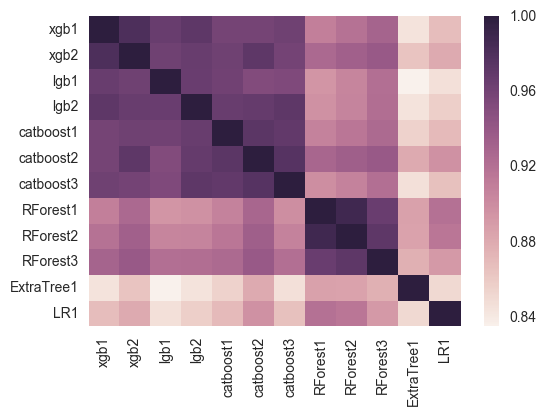

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
corr = train_meta[models_names].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Try weighting models

In [39]:
train_meta[models_names].head()

,xgb1,xgb2,lgb1,lgb2,catboost1,catboost2,catboost3,RForest1,RForest2,RForest3,ExtraTree1,LR1
0,0.049214,0.038178,0.034175,0.037735,0.038324,0.037233,0.035312,0.039965,0.039412,0.042134,0.051316,0.511523
1,0.044588,0.029538,0.039044,0.031475,0.033275,0.031951,0.030196,0.028709,0.031707,0.030566,0.033507,0.500043
2,0.034072,0.023046,0.014451,0.018830,0.019173,0.020481,0.019945,0.023162,0.022777,0.026969,0.029169,0.406342
3,0.021312,0.014280,0.013969,0.015773,0.014852,0.016024,0.015207,0.016184,0.016653,0.015075,0.024602,0.306179
4,0.062117,0.035459,0.029056,0.033303,0.028968,0.035890,0.036607,0.044305,0.041794,0.043107,0.034419,0.511595


In [22]:
#xgb1: 0.288046013899
#xgb2: 0.284421805069
#lgb1: 0.28742875413
#lgb2: 0.287559384506
#catboost1: 0.28591085648
#catboost2: 0.280604361918
#catboost3: 0.285791647191
#RForest1: 0.274770010978
#RForest2: 0.276164442753
#RForest3: 0.27634030336
#ExtraTree1: 0.255998723511
#LR1: 0.270042410499
l_weights = []
l_weights.append({'xgb1': 0.32, 'xgb2': 0.09, 'lgb1': 0.17, 'lgb2': 0.17, 'catboost1': 0.07, 'catboost2': 0.03, 
                  'catboost3': 0.07, 'RForest1': 0.01, 'RForest2': 0.02, 'RForest3': 0.02, 'ExtraTree1': 0.01, 'LR1': 0.02 })
l_weights.append({'xgb1': 0.35, 'xgb2': 0.06, 'lgb1': 0.20, 'lgb2': 0.20, 'catboost1': 0.05, 'catboost2': 0.02, 
                  'catboost3': 0.05, 'RForest1': 0.01, 'RForest2': 0.01, 'RForest3': 0.02, 'ExtraTree1': 0.01, 'LR1': 0.02 })
l_weights.append({'xgb1': 0.25, 'xgb2': 0.05, 'lgb1': 0.20, 'lgb2': 0.20, 'catboost1': 0.07, 'catboost2': 0.03, 
                  'catboost3': 0.07, 'RForest1': 0.01, 'RForest2': 0.02, 'RForest3': 0.04, 'ExtraTree1': 0.02, 'LR1': 0.03 })
l_weights.append({'xgb1': 0.26, 'xgb2': 0.07, 'lgb1': 0.15, 'lgb2': 0.15, 'catboost1': 0.12, 'catboost2': 0.05, 
                  'catboost3': 0.12, 'RForest1': 0.01, 'RForest2': 0.02, 'RForest3': 0.02, 'ExtraTree1': 0.01, 'LR1': 0.02 })
l_weights.append({'xgb1': 0.26, 'xgb2': 0.07, 'lgb1': 0.16, 'lgb2': 0.16, 'catboost1': 0.08, 'catboost2': 0.04, 
                  'catboost3': 0.08, 'RForest1': 0.01, 'RForest2': 0.03, 'RForest3': 0.07, 'ExtraTree1': 0.01, 'LR1': 0.03 })
l_weights.append({'xgb1': 0.5, 'xgb2': 0.05, 'lgb1': 0.12, 'lgb2': 0.12, 'catboost1': 0.06, 'catboost2': 0.03, 
                  'catboost3': 0.06, 'RForest1': 0.01, 'RForest2': 0.01, 'RForest3': 0.02, 'ExtraTree1': 0.01, 'LR1': 0.01 })
l_weights.append({'xgb1': 0.25, 'xgb2': 0.05, 'lgb1': 0.20, 'lgb2': 0.20, 'catboost1': 0.06, 'catboost2': 0.03, 
                  'catboost3': 0.06, 'RForest1': 0.01, 'RForest2': 0.01, 'RForest3': 0.02, 'ExtraTree1': 0.01, 'LR1': 0.10 })
l_weights.append({'xgb1': 0.15, 'xgb2': 0.05, 'lgb1': 0.3, 'lgb2': 0.3, 'catboost1': 0.06, 'catboost2': 0.03, 
                  'catboost3': 0.06, 'RForest1': 0.01, 'RForest2': 0.01, 'RForest3': 0.01, 'ExtraTree1': 0.01, 'LR1': 0.01 })
l_weights.append({'xgb1': 0.325, 'xgb2': 0.09, 'lgb1': 0.17, 'lgb2': 0.17, 'catboost1': 0.07, 'catboost2': 0.03, 
                  'catboost3': 0.08, 'RForest1': 0.01, 'RForest2': 0.02, 'RForest3': 0.02, 'ExtraTree1': 0.01, 'LR1': 0.005 })
l_weights.append({'xgb1': 0.16, 'xgb2': 0.04, 'lgb1': 0.31, 'lgb2': 0.31, 'catboost1': 0.05, 'catboost2': 0.03, 
                  'catboost3': 0.05, 'RForest1': 0.01, 'RForest2': 0.01, 'RForest3': 0.01, 'ExtraTree1': 0.01, 'LR1': 0.01 })
l_weights.append({'xgb1': 0.31, 'xgb2': 0.02, 'lgb1': 0.25, 'lgb2': 0.25, 'catboost1': 0.05, 'catboost2': 0.03, 
                  'catboost3': 0.05, 'RForest1': 0.005, 'RForest2': 0.01, 'RForest3': 0.01, 'ExtraTree1': 0.01, 'LR1': 0.005 })
l_weights.append({'xgb1': 0.10, 'xgb2': 0.01, 'lgb1': 0.40, 'lgb2': 0.40, 'catboost1': 0.015, 'catboost2': 0.01, 
                  'catboost3': 0.01, 'RForest1': 0.001, 'RForest2': 0.01, 'RForest3': 0.01, 'ExtraTree1': 0.01, 'LR1': 0.005 })
    
for weights in l_weights:
    sum = 0
    train_meta['weighted_pred'] = 0
    test_meta['weighted_pred'] = 0
    for w in weights:
        sum += weights[w]
        train_meta['weighted_pred'] += train_meta[w] * weights[w]
        test_meta['weighted_pred'] += test_meta[w]  * weights[w]
    print(eval_gini(y, train_meta['weighted_pred']))
    print(sum)
    print('-------------')

0.288781954259
1.0
-------------
0.288893072662
1.0
-------------
0.288515743622
0.99
-------------
0.288769470153
1.0000000000000002
-------------
0.288398039086
1.0000000000000002
-------------
0.288853786057
1.0
-------------
0.285686092729
1.0
-------------
0.289231596214
1.0
-------------
0.289171385954
1.0
-------------
0.289239984643
1.0000000000000002
-------------
0.289372613267
1.0
-------------
0.289206873943
0.9810000000000001
-------------


In [84]:
weights = {'xgb1': 0.31, 'xgb2': 0.02, 'lgb1': 0.25, 'lgb2': 0.25, 'catboost1': 0.05, 'catboost2': 0.03, 
                  'catboost3': 0.05, 'RForest1': 0.005, 'RForest2': 0.01, 'RForest3': 0.01, 'ExtraTree1': 0.01, 'LR1': 0.005 }

train_meta['weighted_pred'] = 0
test_meta['weighted_pred'] = 0
sum = 0
for w in weights:
    sum += weights[w]
    train_meta['weighted_pred'] += train_meta[w] * weights[w]
    test_meta['weighted_pred'] += test_meta[w]  * weights[w]
print(eval_gini(y, train_meta['weighted_pred']))
print(sum)
print('-------------')

0.290012923856
1.0
-------------


In [85]:
sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = test_meta['weighted_pred']
sub.to_csv('stacked_2_weighted_stratified.csv', index=False)

# Using log-odds and mean ranks

In [108]:
# Load from some public kernels
df_public_kernel_valid = pd.read_csv('public_kernels/NN_EntityEmbed_10fold-val_preds.csv')
df_public_kernel_test = pd.read_csv('public_kernels/NN_EntityEmbed_10fold-sub.csv')
train_meta['NN_EntityEmbed'] = df_public_kernel_valid['0']
test_meta['NN_EntityEmbed'] = df_public_kernel_test['target']

In [ ]:
# Apply log-odds transformation, regularize, and take standardized mean
logits = concat_df.applymap(lambda x: np.log(x/(1-x)))
logits *= (1 - ALPHA*logits**2)
stdevs = logits.std()  
w = .2/stdevs
wa = (w*logits).sum(axis=1)/w.sum()

In [ ]:
# PROBABLY USE THIS

# Apply ranking, normalization and averaging
concat_df["target"] = (concat_df.rank() / concat_df.shape[0]).mean(axis=1)
concat_df.drop(cols, axis=1, inplace=True)

# Read and concatenate submissions
outs = [pd.read_csv(os.path.join(submissions_path, f), index_col=0)\
        for f in all_files]
concat_df = pd.concat(outs, axis=1)
cols = list(map(lambda x: "target_" + str(x), range(len(concat_df.columns))))
concat_df.columns = cols

In [111]:
#models_use = ['xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1', 'catboost2', 'catboost3', 'RForest1', 'RForest2', 'RForest3', 'ExtraTree1', 'LR1', 'NN_EntityEmbed']
models_use = ['xgb1', 'lgb1', 'lgb2', 'catboost1', 'NN_EntityEmbed']
mean_ranks = (train_meta[models_use].rank() / train_meta.shape[0]).mean(axis=1)
print((eval_gini(y, mean_ranks)))

0.290323179537


# Stacking with mean ranks or log odds

In [188]:
models_use = ['xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1', 'catboost2', 'catboost3', 'RForest1', 'RForest2', 'RForest3', 'ExtraTree1', 'LR1', 'NN_EntityEmbed']
models_use = ['xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1', 'catboost2', 'catboost3', 'RForest1', 'RForest3', 'LR1', 'NN_EntityEmbed'] #0.290696537205 #0.290631212567 
#models_use = ['xgb1', 'xgb2', 'lgb1', 'lgb2', 'catboost1', 'catboost3', 'RForest1', 'RForest3', 'LR1', 'NN_EntityEmbed']              #0.29063358156  #0.290558840017
# Compute ranks for each model
rank_columns = []
for m in models_use:
    train_meta[m + '_rank'] = train_meta[m].rank() / train_meta.shape[0]
    test_meta[m + '_rank'] = test_meta[m].rank() / test_meta.shape[0]
    rank_columns.append(m + '_rank')

In [189]:
# K-fold CV for hyperparemeter tuning of the stacked model (LR)
y_valid_pred = 0*y
extra_features = []
stacking_model = LogisticRegression(C=5, fit_intercept=True)
val_gini_stack = []
for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
    X_train, X_valid = train_meta.loc[train_index, rank_columns].copy(), train_meta.loc[test_index, rank_columns].copy()
    stacking_model.fit(X_train, y_train)
    print(stacking_model.coef_)
    print(stacking_model.intercept_ )
    pred = stacking_model.predict_proba(X_valid)[:,1]
    val_gini_stack.append(eval_gini(y_valid, pred))
    print("Val Gini = ", str(val_gini_stack[-1]))
    y_valid_pred.iloc[test_index] = pred 
print(np.mean(val_gini_stack))
print("Val Gini = ", str(eval_gini(y, y_valid_pred)))

[[ 0.56694394 -0.26109092  0.54588509  0.04930208  0.36488222 -0.35267553
   0.39455724 -0.22943743  0.36151151 -0.03081672  0.46452053]]
[-4.33845315]
Val Gini =  0.295728061086
[[ 0.54692849 -0.33557754  0.52991178  0.07307778  0.36509989 -0.30431096
   0.31107822 -0.22470054  0.39014001  0.00601314  0.53418532]]
[-4.3485683]
Val Gini =  0.28915771411
[[ 0.79958212 -0.48410973  0.51266035 -0.02170763  0.26468171 -0.35220213
   0.50596225 -0.1802738   0.42069866 -0.03175609  0.45414021]]
[-4.34701222]
Val Gini =  0.28877589424
[[  7.10696144e-01  -3.34657260e-01   5.05342018e-01   1.40245016e-01
    4.52141952e-01  -5.45635393e-01   4.03408566e-01  -1.62831983e-01
    2.95882217e-01   6.77923095e-04   4.06772628e-01]]
[-4.33807014]
Val Gini =  0.294993175527
[[ 0.63498034 -0.53480705  0.5882816   0.27645017  0.38423141 -0.39267648
   0.24679846 -0.16444583  0.37341903 -0.01783521  0.50225036]]
[-4.35212088]
Val Gini =  0.284838462701
0.290698661533
Val Gini =  0.290632940117


In [192]:
# With LR
# Fit a new model, S (i.e the stacking model) to train_meta, using predictions of other models as features. 
# Optionally, include other features from the original training dataset or engineered features
stacking_model = LogisticRegression(C=5)
stacking_model.fit(train_meta[rank_columns], y)
# Use the stacked model S to make final predictions on test_meta
res = stacking_model.predict_proba(test_meta[rank_columns])[:,1]

sub = pd.DataFrame()
sub['id'] = test_meta.id
sub['target'] = res
sub.to_csv('stacked_2_lr_stratified.csv', index=False)
print(stacking_model.coef_)
print(stacking_model.intercept_ )

[[ 0.65217836 -0.39287841  0.53619447  0.10421158  0.36641749 -0.39063114
   0.37254124 -0.19116798  0.36863654 -0.01384492  0.47278352]]
[-4.34485148]


In [193]:
test_meta.head()

,id,xgb1,xgb2,lgb1,lgb2,catboost1,catboost2,catboost3,RForest1,RForest2,...,xgb2_rank,lgb1_rank,lgb2_rank,catboost1_rank,catboost2_rank,catboost3_rank,RForest1_rank,RForest3_rank,LR1_rank,NN_EntityEmbed_rank
0,0,0.038611,0.023903,0.025420,0.025559,0.023955,0.023623,0.024433,0.023149,0.023099,...,0.251206,0.322029,0.317567,0.266391,0.233828,0.284036,0.160053,0.219015,0.281517,0.475982
1,1,0.032867,0.023530,0.023353,0.022532,0.023760,0.023367,0.022031,0.025149,0.024097,...,0.239380,0.258602,0.225554,0.260518,0.225471,0.210697,0.216500,0.176814,0.250817,0.279407
2,2,0.034893,0.024356,0.021546,0.022635,0.022074,0.024145,0.023330,0.027521,0.026315,...,0.265768,0.204728,0.228670,0.210119,0.251002,0.249840,0.290317,0.210399,0.224122,0.246697
3,3,0.022260,0.014952,0.016135,0.014097,0.014309,0.015621,0.014096,0.017336,0.017242,...,0.029387,0.068201,0.031107,0.034473,0.031708,0.030565,0.041165,0.034994,0.092570,0.056965
4,4,0.062924,0.040745,0.039816,0.038227,0.038177,0.037614,0.037237,0.043257,0.043151,...,0.705585,0.684544,0.655449,0.649888,0.642314,0.635101,0.732599,0.728031,0.659231,0.558137
